In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import plotly.io as pio
pio.templates.default = "plotly_white"
import pandas as pd
from pathlib import Path
from tqdm.autonotebook import tqdm
from IPython.display import display, HTML
# %load_ext autoreload
# %autoreload 2
np.random.seed()
tqdm.pandas()

/tmp/ipykernel_38573/1114571209.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
DATA_FOLDER_PATH = "/home/bilal326/Time_Series/data/london_smart_meters"

block_df = pd.read_parquet(f"{DATA_FOLDER_PATH}/preprocessed/london_smart_meters_merged_block_0-7.parquet")

from data_utils import compact_to_expanded

exp_block_df = compact_to_expanded(block_df[block_df.file=="block_7"], timeseries_col = 'energy_consumption',\
                                   static_cols = ["frequency", "series_length", "stdorToU", "Acorn", "Acorn_grouped",\
                                                   "file"],time_varying_cols = ['holidays', 'visibility', 'windBearing', 'temperature','dewPoint',\
                                                                                'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon', 'humidity', 'summary'],\
                                                                                    ts_identifier = "LCLid")

# Taking a single time series from the block
ts_df = exp_block_df[exp_block_df.LCLid=="MAC000193"].set_index("timestamp")

  0%|          | 0/50 [00:00<?, ?it/s]

## Seasonal Decompose

Decomposes into 3 parts
- res.observed   # Original time series (same as input)
- res.trend      # Smoothed long-term trend
- res.seasonal   # Repeating seasonal pattern (weekly here)
- res.resid      # Noise or leftover after removing trend and seasonality


In [3]:
ts_df.head()

,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
timestamp,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,MAC000193,0.368,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.99,229,12.12,10.97,1008.10,12.12,5.90,rain,partly-cloudy-night,0.93,Mostly Cloudy
2012-01-01 00:30:00,MAC000193,0.386,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.99,229,12.12,10.97,1008.10,12.12,5.90,rain,partly-cloudy-night,0.93,Mostly Cloudy
2012-01-01 01:00:00,MAC000193,0.170,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.89,238,12.59,11.02,1007.88,12.59,6.06,rain,cloudy,0.90,Overcast
2012-01-01 01:30:00,MAC000193,0.021,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,12.89,238,12.59,11.02,1007.88,12.59,6.06,rain,cloudy,0.90,Overcast
2012-01-01 02:00:00,MAC000193,0.038,30min,37872,ToU,ACORN-D,Affluent,block_7,NO_HOLIDAY,11.54,229,12.45,11.04,1007.95,12.45,5.31,rain,partly-cloudy-night,0.91,Mostly Cloudy


In [4]:
ts_df = ts_df.sort_index()
ts_df = ts_df.asfreq("30min")  # if 30-min frequency is expected
ts_df["energy_consumption"] = ts_df["energy_consumption"].interpolate(method='time')


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ts_df["energy_consumption_scaled"] = scaler.fit_transform(
    ts_df["energy_consumption"].values.reshape(-1, 1)
).squeeze()


In [6]:
ts = ts_df["energy_consumption_scaled"]


In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

# Decompose with a simple moving average filter
res = seasonal_decompose(
    ts,                         # pandas Series with datetime index
    period=7*48,                # e.g., weekly seasonality for 48 obs/day
    model="additive",
    extrapolate_trend="freq",  # extrapolates trend to match length
    filt=np.repeat(1/(30*48), 30*48)  # convolution filter for trend (e.g., ~30 days)
)


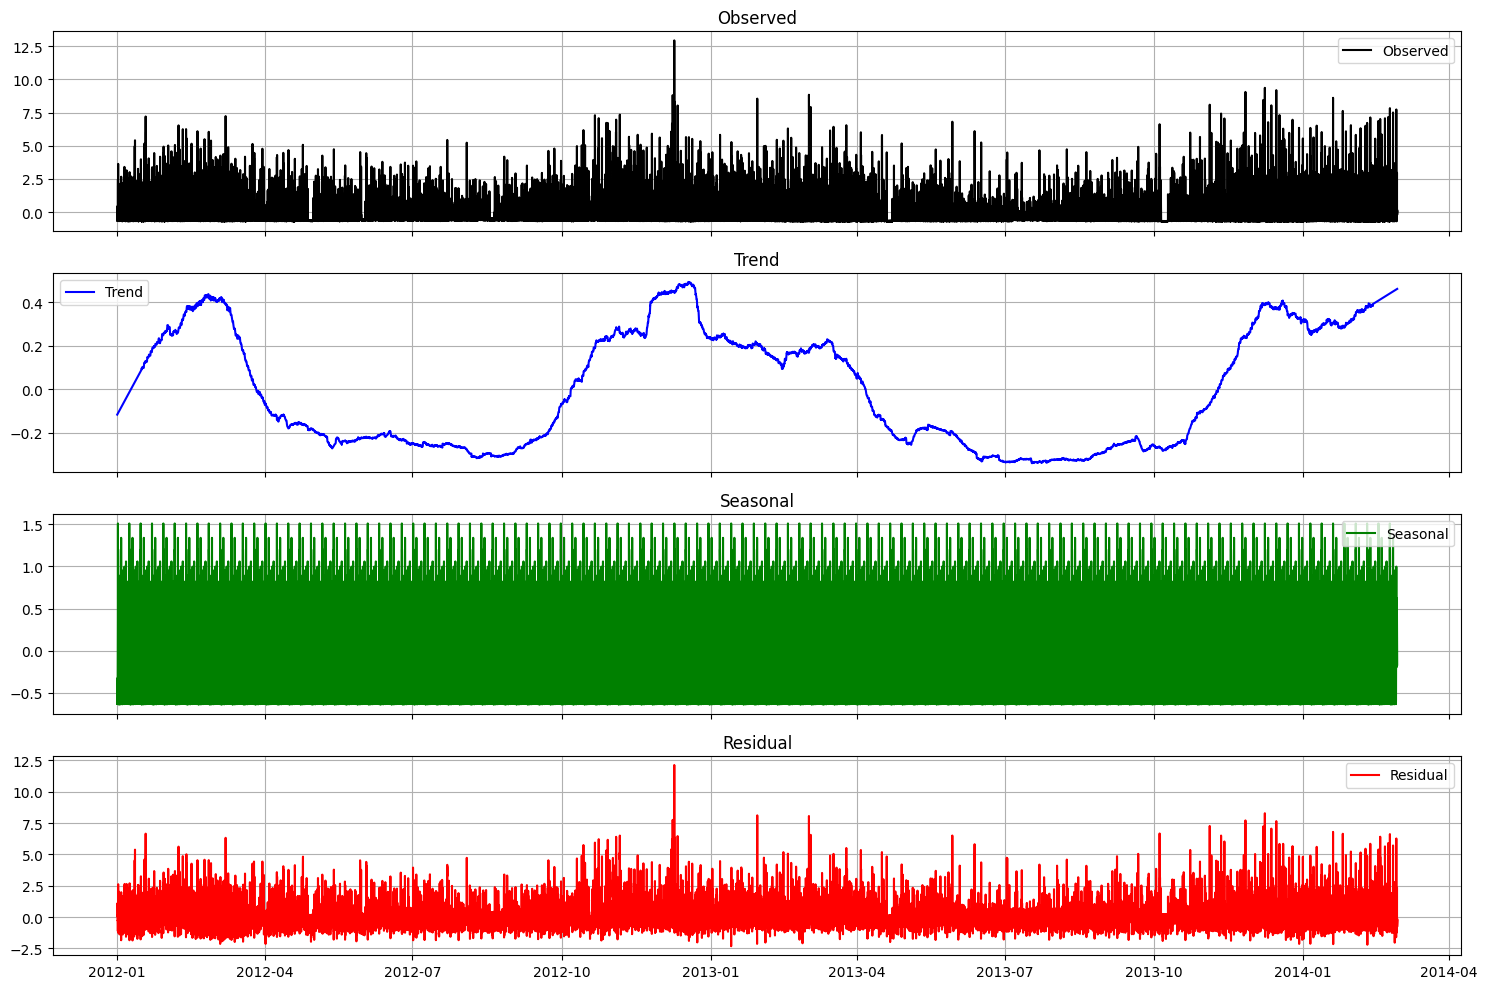

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

# Observed
axs[0].plot(ts_df.index, res.observed, label='Observed', color='black')
axs[0].set_title("Observed")

# Trend
axs[1].plot(ts_df.index, res.trend, label='Trend', color='blue')
axs[1].set_title("Trend")

# Seasonal
axs[2].plot(ts_df.index, res.seasonal, label='Seasonal', color='green')
axs[2].set_title("Seasonal")

# Residual
axs[3].plot(ts_df.index, res.resid, label='Residual', color='red')
axs[3].set_title("Residual")

# Formatting
for ax in axs:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


## Method 2

- seasonal_decompose() uses simple moving average (convolution).
- The below code uses LOWESS (Locally Weighted Scatterplot Smoothing), which is:
    - Better at capturing nonlinear trends.
    - More robust to outliers or changes.

In [12]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import pandas as pd
import numpy as np

# INPUTS
series = ts_df['energy_consumption']
period = 7 * 48
lo_frac = 0.6
lo_delta = 0.01

# STEP 1: LOWESS Trend
trend = lowess(
    series.values, 
    np.arange(len(series)), 
    frac=lo_frac, 
    delta=lo_delta * len(series),
    return_sorted=False
)

# STEP 2: Detrended signal
detrended = series.values - trend

# STEP 3: Period-wise seasonal average
period_averages = np.array([detrended[i::period].mean() for i in range(period)])
period_averages -= period_averages.mean()  # Center the seasonal component

# STEP 4: Repeat seasonal pattern
seasonal = np.tile(period_averages, len(detrended) // period + 1)[:len(detrended)]

# STEP 5: Residual
resid = detrended - seasonal

# Put everything in a DataFrame
decomposed_df = pd.DataFrame({
    "observed": series.values,
    "trend": trend,
    "seasonal": seasonal,
    "resid": resid
}, index=series.index)
    

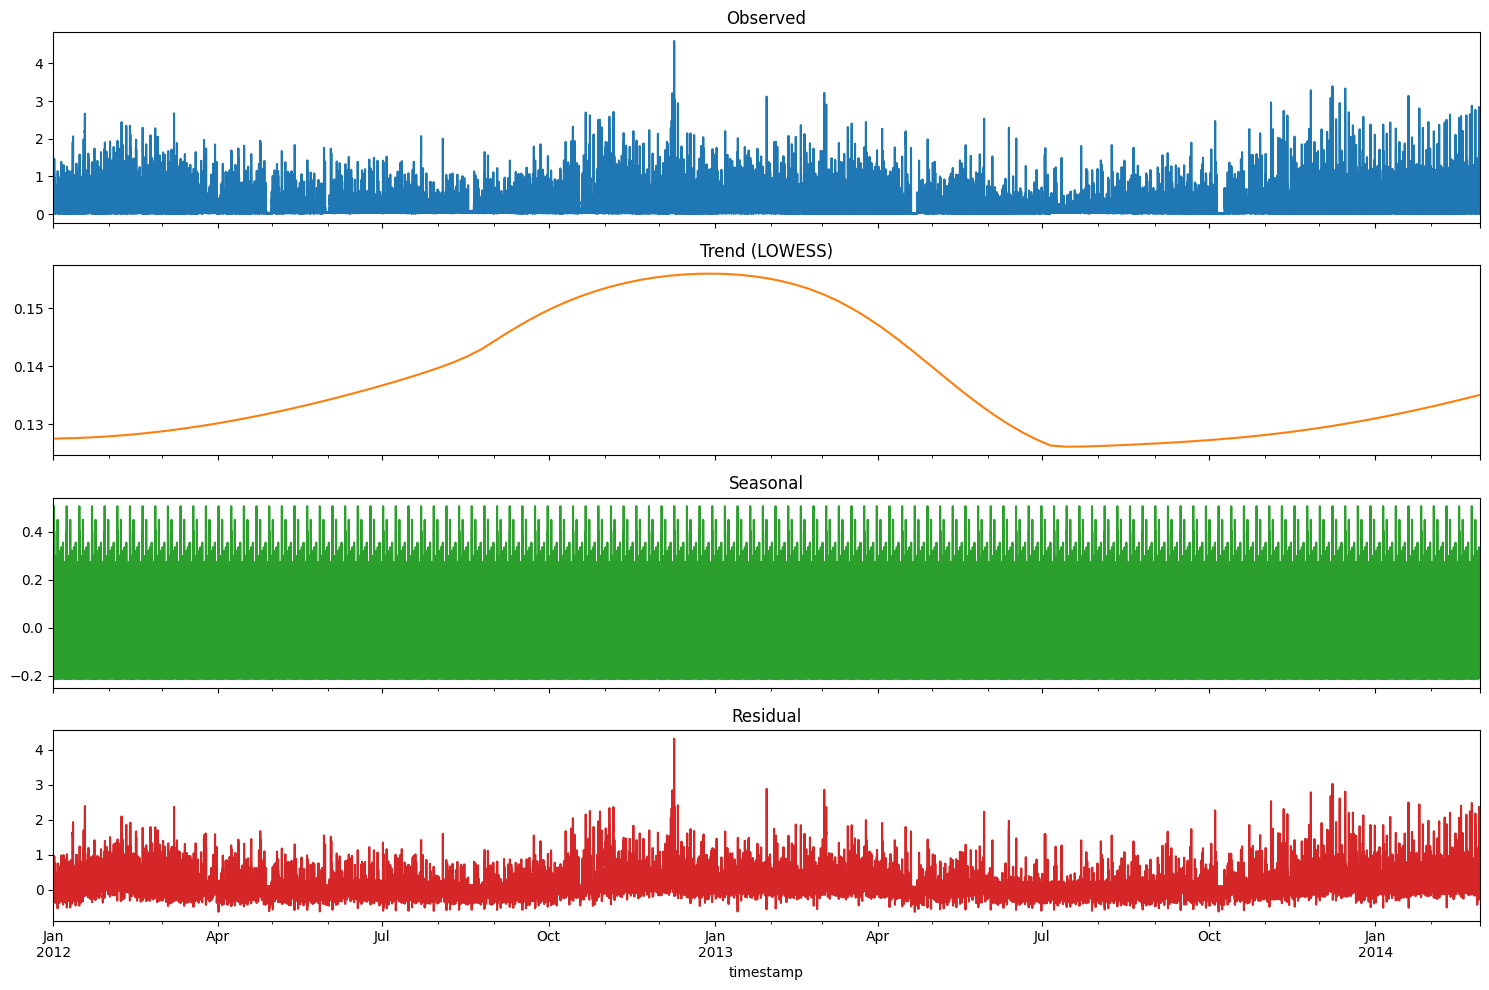

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

decomposed_df[['observed', 'trend', 'seasonal', 'resid']].plot(subplots=True, ax=axs, legend=False)
axs[0].set_title("Observed")
axs[1].set_title("Trend (LOWESS)")
axs[2].set_title("Seasonal")
axs[3].set_title("Residual")

plt.tight_layout()
plt.show()


In [14]:
from sklearn.linear_model import RidgeCV
import numpy as np
import pandas as pd

# Inputs
series = pd.Series(ts.squeeze(), index=ts_df.index)
seasonality_col = "hour"  # Extract from datetime index
n_terms = 5  # number of Fourier terms

# STEP 1: Extract cycle values from datetime
cycle = getattr(series.index, seasonality_col)
max_cycle = cycle.max()

# STEP 2: Build Fourier basis
def get_fourier_terms(cycle_vals, n_terms, max_cycle):
    X_sin = np.array([np.sin(2 * np.pi * cycle_vals * i / max_cycle) for i in range(1, n_terms+1)]).T
    X_cos = np.array([np.cos(2 * np.pi * cycle_vals * i / max_cycle) for i in range(1, n_terms+1)]).T
    return np.hstack([X_sin, X_cos])

X = get_fourier_terms(cycle, n_terms, max_cycle)

# STEP 3: Trend estimation
trend = lowess(series.values, np.arange(len(series)), frac=0.6, delta=0.01 * len(series), return_sorted=False)

# STEP 4: Detrend
detrended = series.values - trend

# STEP 5: Ridge Regression
model = RidgeCV(fit_intercept=False).fit(X, detrended)

# STEP 6: Seasonal component from model
seasonal = model.predict(X)

# STEP 7: Residual
resid = detrended - seasonal

# Final DataFrame
decomposed_df = pd.DataFrame({
    "observed": series.values,
    "trend": trend,
    "seasonal": seasonal,
    "resid": resid
}, index=series.index)


#### 🔁 Comparison with Previous Two Methods

| Aspect                     | `seasonal_decompose()`               | Your Manual LOWESS STL               | This (Fourier + RidgeCV)                    |
| -------------------------- | ------------------------------------ | ------------------------------------ | ------------------------------------------- |
| **Trend Estimation**       | Moving Average (via convolution)     | LOWESS                               | LOWESS                                      |
| **Seasonality Estimation** | Averaging by periodic position       | Averaging by periodic position       | **Fitting sin & cos basis** using Ridge     |
| **Seasonality Type**       | Fixed pattern (repeats every period) | Fixed pattern (repeats every period) | **Flexible & smooth sinusoidal**            |
| **Noise/Outlier Handling** | Not robust                           | Better (via LOWESS)                  | Better (via regularized fit)                |
| **Interpretability**       | Easy (avg by position)               | Easy                                 | Slightly harder but more powerful           |
| **Multiple Seasonality**   | Not supported                        | Manually extendable                  | Easily extendable with more terms or cycles |



#### 🔬 Summary

This method is **more mathematically elegant**:

* You use **sinusoids to capture cycles** — ideal for patterns like **daily, hourly, weekly, etc.**
* **Ridge regression** avoids overfitting by penalizing large coefficients.
* It’s **similar to what the FourierDecomposition class in your `src` file does**, just implemented manually.


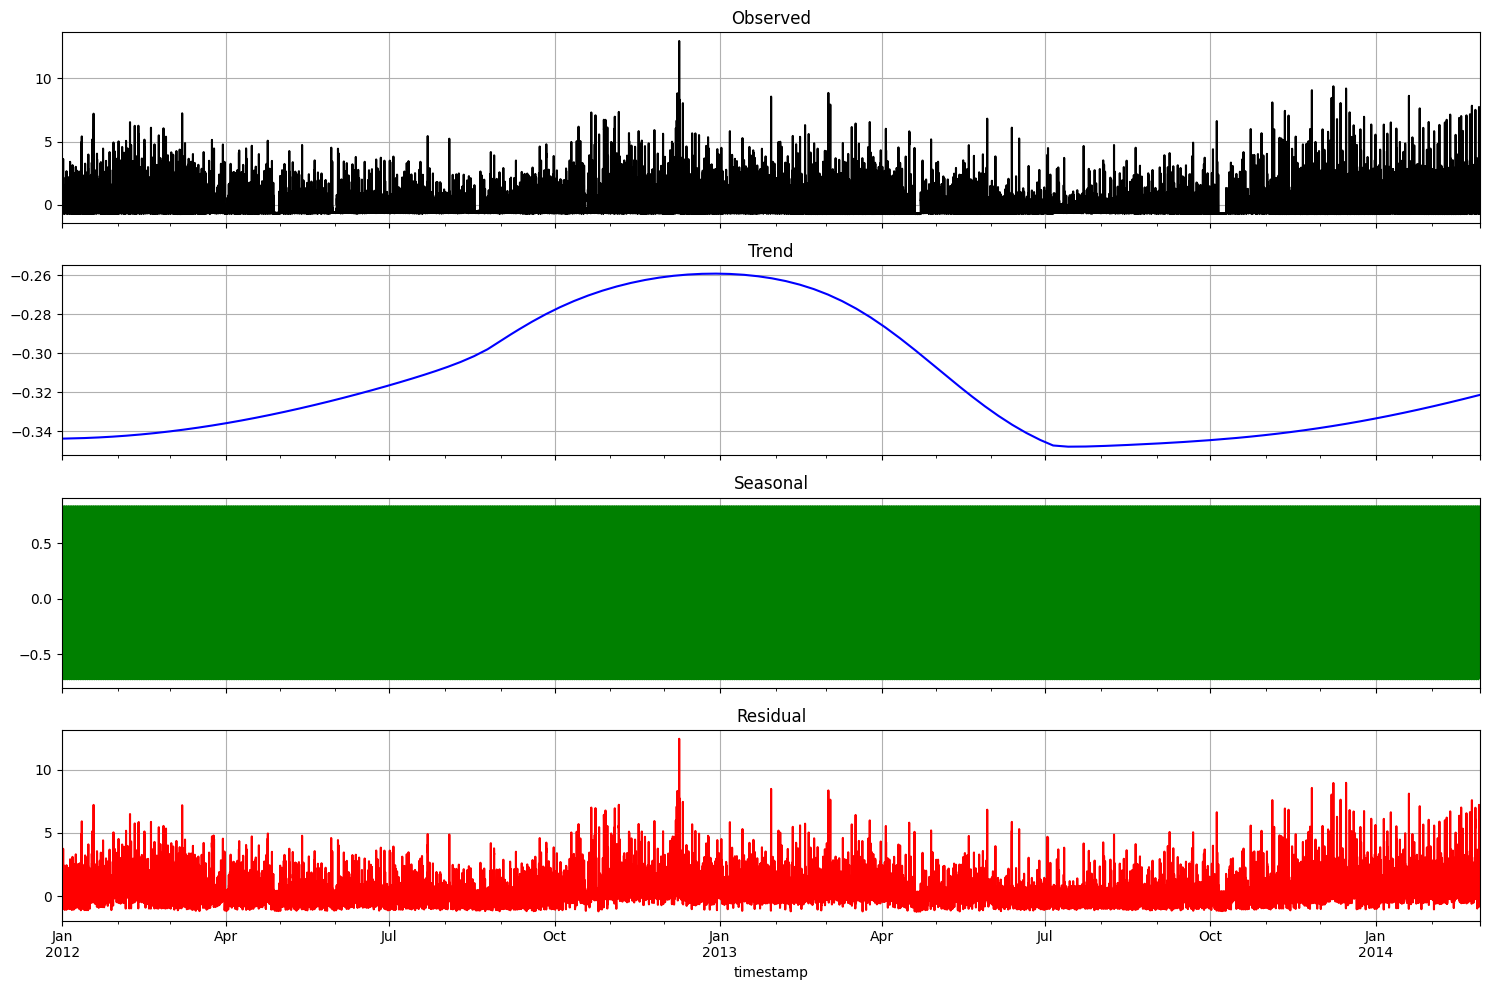

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

decomposed_df["observed"].plot(ax=axs[0], title="Observed", color="black")
decomposed_df["trend"].plot(ax=axs[1], title="Trend", color="blue")
decomposed_df["seasonal"].plot(ax=axs[2], title="Seasonal", color="green")
decomposed_df["resid"].plot(ax=axs[3], title="Residual", color="red")

for ax in axs:
    ax.grid(True)

plt.tight_layout()
plt.show()
